In [1]:
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

from pyspark.sql import SparkSession, Row
import pyspark.sql.functions as spf
from pyspark.sql.types import *

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
sc

<SparkContext master=yarn appName=PySparkShell>

In [3]:
spark = SparkSession.builder.appName("mob202203").getOrCreate()

In [4]:
data = spark.read.json("/user/mob202203/marat_dir_model2/")

data.printSchema()

root
 |-- experiments: struct (nullable = true)
 |    |-- CONTEXTUAL: string (nullable = true)
 |-- latency: double (nullable = true)
 |-- message: string (nullable = true)
 |-- recommendation: long (nullable = true)
 |-- time: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- track: long (nullable = true)
 |-- user: long (nullable = true)



In [5]:
# data.shape
print((data.count(), len(data.columns)))

(74454, 8)


In [6]:
data.columns

['experiments',
 'latency',
 'message',
 'recommendation',
 'time',
 'timestamp',
 'track',
 'user']

In [7]:
data.show(10)

+-----------+--------------------+-------+--------------+----+-------------+-----+----+
|experiments|             latency|message|recommendation|time|    timestamp|track|user|
+-----------+--------------------+-------+--------------+----+-------------+-----+----+
|       [T1]|0.001213788986206...|   next|         14252| 1.0|1666780095723| 2659|3255|
|       [T1]|4.689693450927734...|   next|          5602|0.12|1666780095728|14252|3255|
|       [T1]|4.863739013671875E-4|   next|          1144|0.33|1666780095732| 5602|3255|
|       [T1]|5.006790161132812E-4|   next|          1496|0.07|1666780095735| 1144|3255|
|       [T1]|4.184246063232422E-4|   next|         27877| 1.0|1666780095738| 1496|3255|
|       [T1]|3.197193145751953E-4|   next|          7018|0.06|1666780095741|27877|3255|
|       [T1]|1.034736633300781...|   last|          null|0.02|1666780095744| 7018|3255|
|       [T1]|4.632472991943359...|   next|          7099| 1.0|1666780095760|24603|7229|
|       [T1]|4.458427429199219E-

## Visualize sessions

In [8]:
experiment = "CONTEXTUAL"

Session = namedtuple("Session", ["timestamp", "tracks", "time"])

schema = ArrayType(StructType([
    StructField("timestamp", LongType(), False),
    StructField("tracks", LongType(), False),
    StructField("time", FloatType(), False)
]))

def sessionize(tracks):
    sessions = []
    session_tracks = 0
    session_time = 0
    for track in tracks:
        session_tracks += 1
        session_time += track["time"]
        if track["message"] == "last":
            sessions.append(Session(timestamp=track["timestamp"], tracks=session_tracks, time=session_time))
            session_tracks = 0
            session_time = 0
    return sessions
            
sessionize_udf = spf.udf(sessionize, schema)

sessions = (
  data
    .groupBy(
        spf.col("user"), 
        spf.col("experiments." + experiment).alias("treatment")
    )
    .agg(
        spf.sort_array(spf.collect_list(spf.struct(
            spf.col("timestamp"),
            spf.col("message"),
            spf.col("time"),
        )).alias("track")).alias("tracks")
    )
    .select(
        spf.col("treatment"),
        spf.explode(sessionize_udf(spf.col("tracks"))).alias("session"),
    )
    .select(
        spf.col("treatment"),
        spf.col("session.*"),
    )
    .toPandas()
    .set_index("timestamp")
    .sort_index()
)

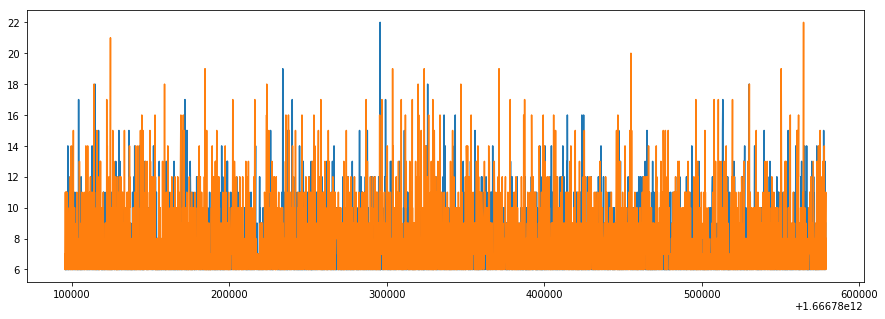

In [9]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    ax.plot(treatment_sessions.index, treatment_sessions["tracks"], label=treatment)

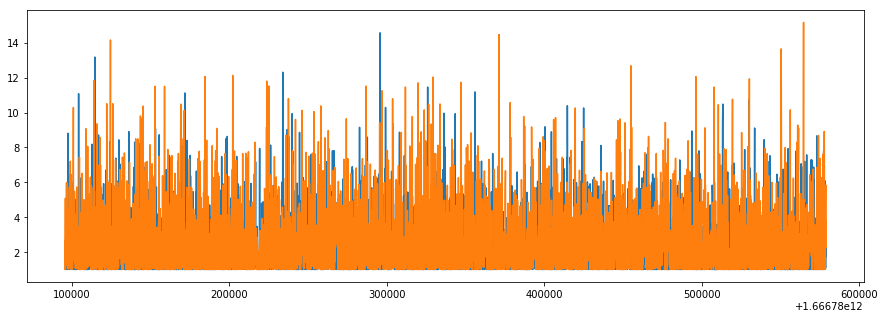

In [10]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    ax.plot(treatment_sessions.index, treatment_sessions["time"], label=treatment)

## Analyze experiment

In [11]:
experiment = "CONTEXTUAL"

user_level_data = (
  data
    .groupBy(
        spf.col("user"), 
        spf.col("experiments." + experiment).alias("treatment")
    )
    .agg(
        spf.count(spf.when(spf.col("message") == "last", spf.col("user"))).alias("sessions"),
        (spf.count("user") / spf.count(spf.when(spf.col("message") == "last", spf.col("user")))).alias("mean_session_length"),
        (spf.sum("time") / spf.count(spf.when(spf.col("message") == "last", spf.col("user")))).alias("mean_session_time"),
        (spf.sum("latency") / spf.count("user")).alias("mean_request_time")
    )
)

metrics = [column for column in user_level_data.columns if column not in ("user", "treatment")]

metric_stats = []
for metric in metrics:
    metric_stats.extend(
        [
            spf.avg(metric).alias("mean_" + metric),
            spf.variance(metric).alias("var_" + metric),
            spf.count(metric).alias("n_" + metric)
        ]
    )
    
treatment_level_data = (
    user_level_data
      .groupBy(spf.col("treatment"))
      .agg(*metric_stats)
      .collect()
)

In [12]:
def dof(n_0, n_1, s2_0, s2_1):
    numerator = (s2_0 / n_0 + s2_1 / n_1) * (s2_0 / n_0 + s2_1 / n_1)
    denominator = s2_0 * s2_0 / n_0 / n_0 / (n_0 - 1) + s2_1 * s2_1 / n_1 / n_1 / (n_1 - 1)
    return numerator / denominator


def ci(n_0, n_1, s2_0, s2_1, alpha=0.05):
    return ss.t.ppf(1 - alpha/2, dof(n_0, n_1, s2_0, s2_1)) * np.sqrt(s2_0 / n_0 + s2_1 / n_1)


effects = []

control = [data for data in treatment_level_data if data["treatment"] == "C"][0]

for row in treatment_level_data:
    if row["treatment"] == "C":
        continue
    
    for metric in metrics:
        control_mean = control["mean_" + metric]
        treatment_mean = row["mean_" + metric]
        
        effect = treatment_mean - control_mean
        conf_int = ci(
            control["n_" + metric],
            row["n_" + metric],
            control["var_" + metric],
            row["var_" + metric],
        )
        effects.append({
            "treatment": row["treatment"],
            "metric": metric,
            "control_mean": control_mean,
            "treatment_mean": treatment_mean,
            "effect": effect / control_mean * 100,
            "lower": (effect - conf_int) / control_mean * 100,
            "upper": (effect + conf_int) / control_mean * 100,
            "significant": (effect + conf_int) * (effect - conf_int) > 0
        })

In [13]:
def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect", 
        "upper", 
        "lower", 
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values("effect", ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
2,T1,mean_session_time,18.2381,21.8554,14.6207,2.22885,2.63535,True
1,T1,mean_session_length,5.60458,6.82047,4.38869,7.22251,7.6273,True
0,T1,sessions,0.20893,2.74256,-2.3247,1.58365,1.58696,False
3,T1,mean_request_time,-1.20837,-0.545356,-1.87139,0.000455199,0.000449698,True
